AO3 analysis: kudos
===========

This notebook presents the code used to generate the plots in [post 5]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses the patterns of which works get kudos.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from ao3db import ao3db
from utils import format_tag, add_log_axis_labels, downsample, hits_v_kudos_plot, rolling_mean, get_topten_fandoms

In [2]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [3]:
db = ao3db()

We expect that reader engagement metrics (kudos, comments, and bookmarks) will all go up with the number of hits. What's the exact scaling?

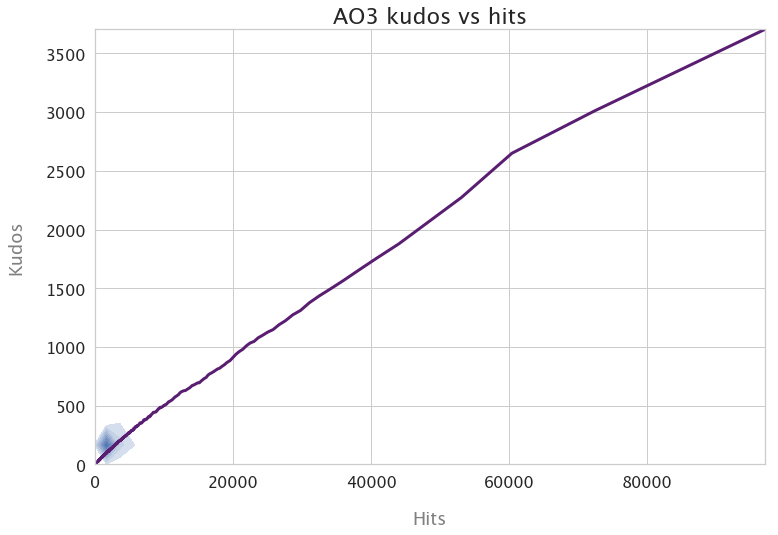

In [4]:
data = db.get_data('Hits', 'Kudos', conditions=["Hits IS NOT NULL"]).dropna()
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
hits, kudos = downsample(data, 'Hits', 'Kudos')
random_subsample = data.sample(frac=0.01)
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.kdeplot(random_subsample['Hits'], random_subsample['Kudos'], ax=ax, shade=True, shade_lowest=False)
ax.plot(hits, rolling_mean(kudos), color=sns.color_palette('dark')[4], lw=3)
ax.set_xlim((0, np.max(hits)))
ax.set_ylim((0, np.max(kudos)))
ax.set_title("AO3 kudos vs hits")
fig.savefig("kudos_v_hits.png")

kudos_vs_hits = (hits, kudos)

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


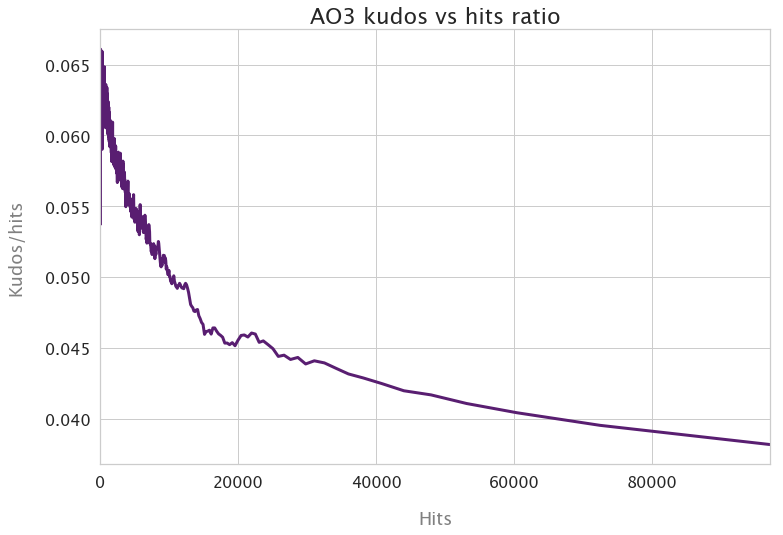

In [5]:
fig, ax = plt.subplots()
hits, kudos = downsample(data, 'Hits', 'Kudos')
random_subsample = data.sample(frac=0.01)

ax.plot(hits, rolling_mean(kudos/hits), color=sns.color_palette('dark')[4], lw=3)
ax.set_xlim((0, np.max(hits)))
ax.set_ylabel("Kudos/hits")
ax.set_xlabel("Hits")
#ax.set_ylim((0, np.max(kudos)))
ax.set_title("AO3 kudos vs hits ratio")
fig.savefig("kudos_v_hits_ratio.png")

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


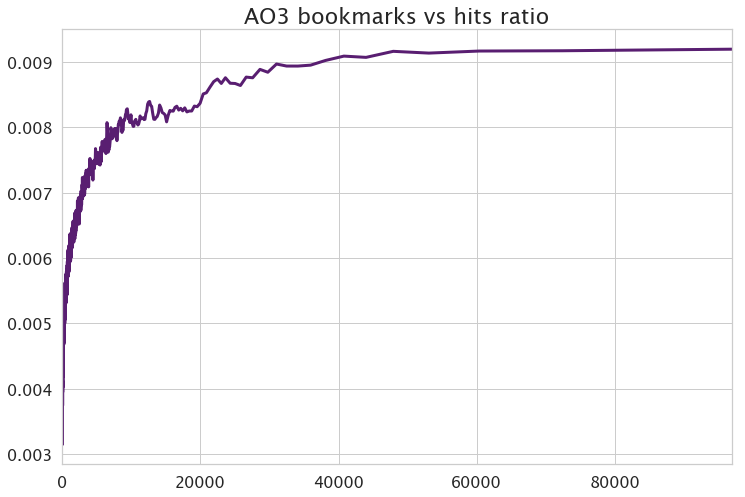

In [6]:
data = db.get_data('Hits', 'Bookmarks', conditions=["Hits IS NOT NULL"]).dropna()
data = data.loc[~(data['Bookmarks'].str.contains('<').fillna(False))]

hits, bookmarks = downsample(data, 'Hits', 'Bookmarks')
random_subsample = data.sample(frac=0.01)

fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
ax.plot(hits, rolling_mean(bookmarks/hits), color=sns.color_palette('dark')[4], lw=3)
ax.set_xlim((0, np.max(hits)))
ax.set_title("AO3 bookmarks vs hits ratio")
fig.savefig('bookmarks_v_hits.png')

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


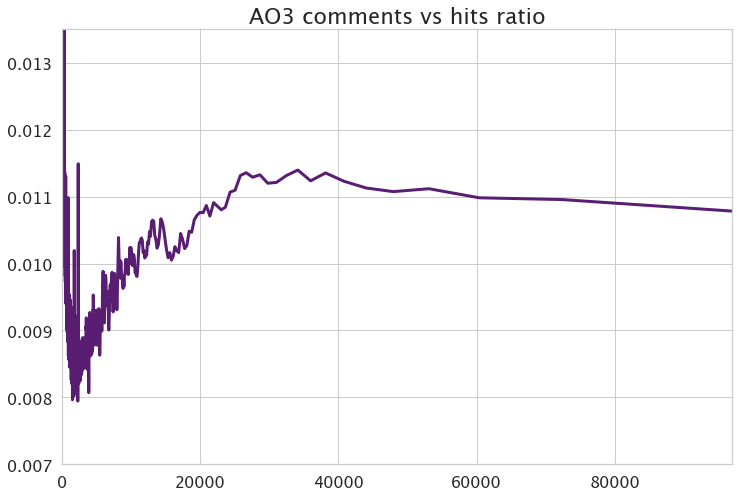

In [7]:
data = db.get_data('Hits', 'Comments', conditions=["Hits IS NOT NULL"]).dropna()
data = data.loc[~(data['Comments'].str.contains('<').fillna(False))]

hits, comments = downsample(data, 'Hits', 'Comments')
random_subsample = data.sample(frac=0.01)

fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
ax.plot(hits, rolling_mean(comments/hits), color=sns.color_palette('dark')[4], lw=3)
ax.set_xlim((0, np.max(hits)))
ax.set_ylim((0.007, 0.0135))
ax.set_title("AO3 comments vs hits ratio")
fig.savefig('comments_v_hits.png')

Now, let's examine a bunch of the other things that could affect the number of kudos for a given number of hits.  

/home/msimet/research/fanstats_private/utils.py:276: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, rolling_mean(y/x), color=cmap(1.0))


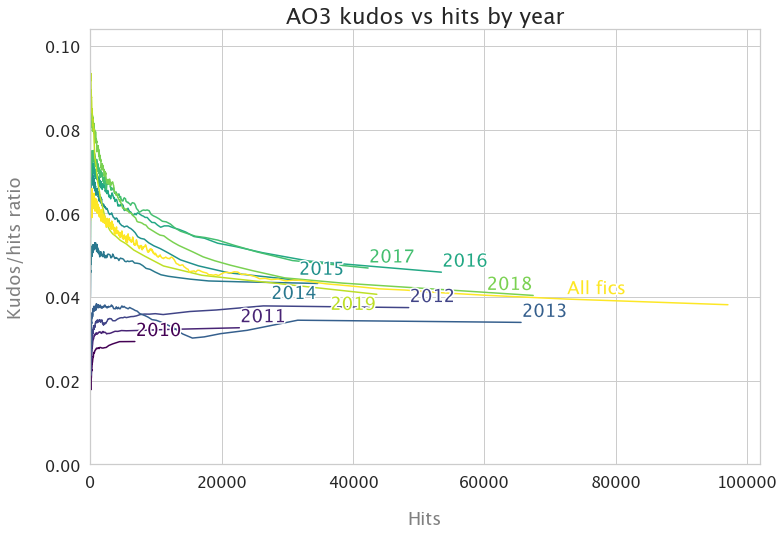

In [8]:
# Kudos vs hit count by year

data = db.get_data('Hits', 'Kudos', 'Date', conditions=["Hits IS NOT NULL"]).dropna()
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
interpolators = []
labels = []
for i, year in enumerate(range(2010, 2020)):
    this = data[data['Date'].dt.year == year]
    interpolators.append(downsample(this, "Hits", "Kudos"))
    labels.append(year)
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_xlim((0, fig.gca().get_xlim()[1]))
fig.gca().set_ylim((0, fig.gca().get_ylim()[1]))
fig.gca().set_title("AO3 kudos vs hits by year")
fig.savefig("kudos_v_hits_per_year.png")

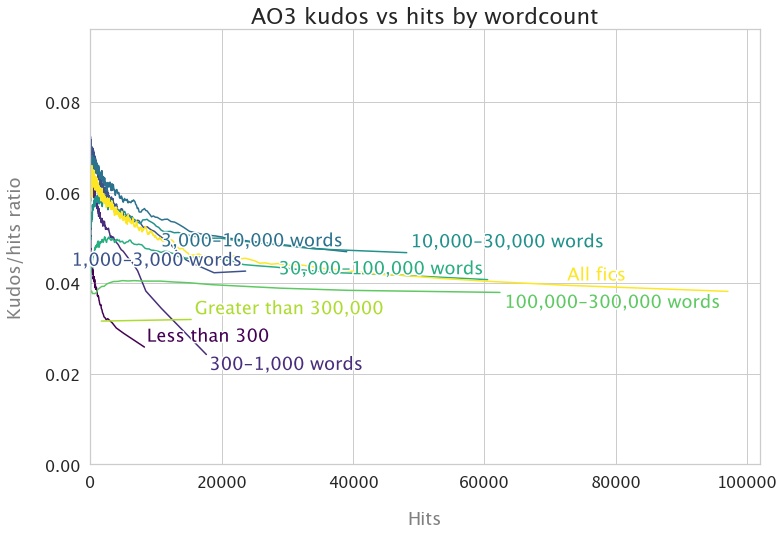

In [9]:
# Kudos vs hit count by word count
data = db.get_data('Hits', 'Kudos', 'Words', conditions=["Hits IS NOT NULL"]).dropna()
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
data = data.replace('', 0)

interpolators = []
labels = []
for i, wordcount_limits in enumerate([(0, 300),
                                      (300, 1000),
                                      (1000, 3000),
                                      (3000, 10000),
                                      (10000, 30000),
                                      (30000, 100000),
                                      (100000, 300000),
                                      (300000, np.inf)]):
    if wordcount_limits[0] == 0:
        label = "Less than {:,}".format(wordcount_limits[1])
    elif wordcount_limits[1] == np.inf:
        label = "Greater than {:,}".format(wordcount_limits[0])
    else:
        label = "{:,}-{:,} words".format(*wordcount_limits)
    labels.append(label)
    this = data[(wordcount_limits[0] <= data['Words']) &
                (data['Words'] < wordcount_limits[1])]
    interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_xlim((0, fig.gca().get_xlim()[1]))
fig.gca().set_ylim((0, fig.gca().get_ylim()[1]))
fig.gca().set_title("AO3 kudos vs hits by wordcount")
fig.savefig("kudos_v_hits_per_wordcount.png")

/home/msimet/research/fanstats_private/utils.py:271: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, rolling_mean(y/x), color=color)


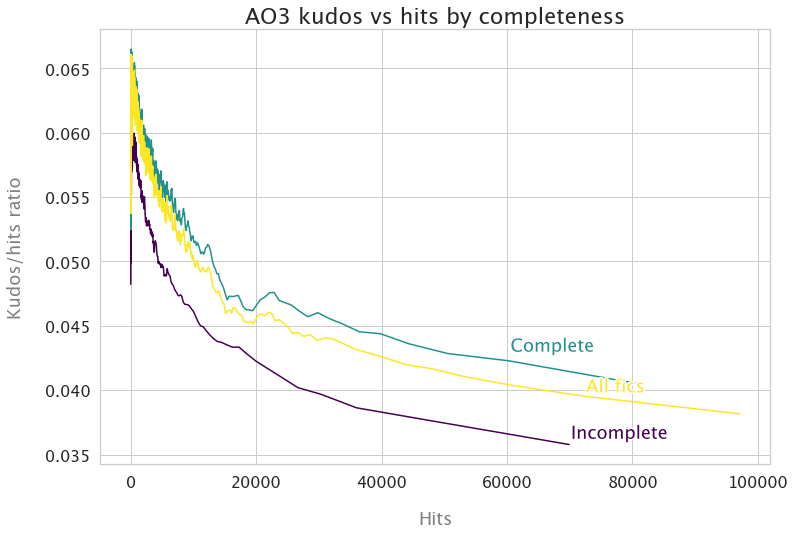

In [10]:
# Kudos vs hits, complete vs incomplete

data = db.get_data('Hits', 'Kudos', 'Complete', "Chapters", conditions=["Hits IS NOT NULL"])
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
interpolators = []
labels = []
for complete, complete_string in [(0, "Incomplete"), 
                                            (1, "Complete")]:
    labels.append(complete_string)
    this = data.query("Complete == {}".format(complete))
    if complete==0:
        this = this.query("Chapters>1")
    interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_title("AO3 kudos vs hits by completeness")
fig.savefig("kudos_v_hits_per_completeness.png")

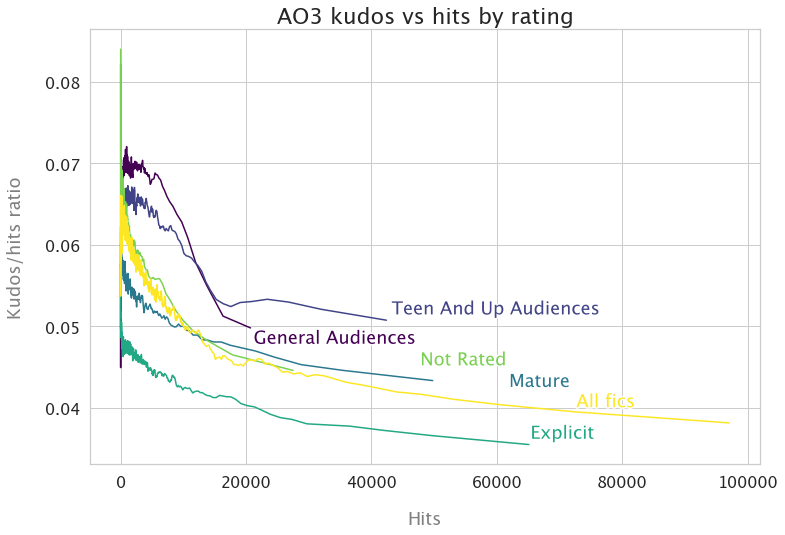

In [11]:
# Kudos vs hits, per rating

data = db.get_data('Hits', 'Kudos', 'Rating', conditions=["Hits IS NOT NULL"])
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
# For some unknown reason, one (1) work in my database has this rating. I don't know either.
data.loc[data['Rating']=="Teen And Up Audiences, Not Rated", 'Rating'] = u"Teen And Up Audiences"
# "No rating" is basically NaN, a processing failure.
data = data.query('Rating != "No rating"')
ratings_data = data

interpolators = []
labels = [u'General Audiences', u'Teen And Up Audiences', u'Mature', u'Explicit', u'Not Rated']
for i, rating in enumerate(labels):
    this = data.query("Rating == '{}'".format(rating))
    interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_title("AO3 kudos vs hits by rating")
fig.savefig("kudos_v_hits_per_rating.png")

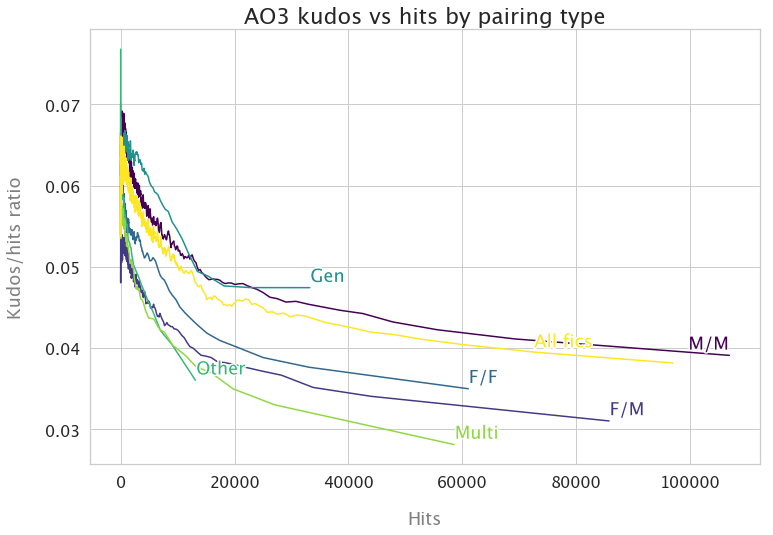

In [12]:
# Kudos vs hits, pairing type
data = db.get_data('Hits', 'Kudos', 'PairingType', conditions=["Hits IS NOT NULL"])
data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
data = data.query("PairingType != 'No category'")
pairing_types = ['M/M', 'F/M', 'F/F', 'Gen', 'Other', 'Multi']
for pt in pairing_types:
    data[pt] = data['PairingType'].str.contains(pt)
interpolators = []
for i, pt in enumerate(pairing_types):
    this = data.loc[data[pt] == True]
    interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, pairing_types, kudos_vs_hits)
fig.gca().set_title("AO3 kudos vs hits by pairing type")
fig.savefig("kudos_v_hits_per_pairing_type.png")

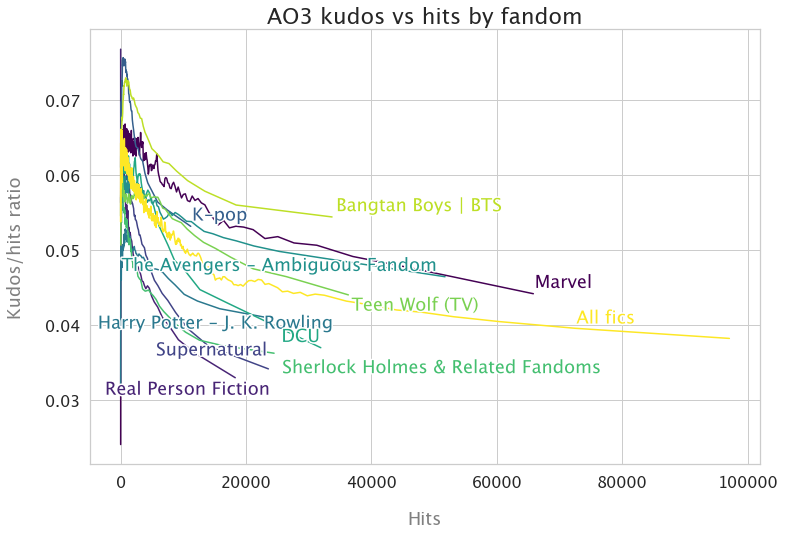

In [13]:
#Kudos vs hits, fandom
fandom_data = get_topten_fandoms(db)

fandom_data = fandom_data.sort_values('ReportedNum', ascending=False)
fandom_data_head = fandom_data.head(10)

data = db.get_data("Hits", "Kudos", "FandomName", conditions=["Hits IS NOT NULL"])
#data = data.loc[~(data['Kudos'].str.contains('<').fillna(False))] #processing error on <20 items
interpolators = []
labels = []
for i, (idx, fandom) in enumerate(fandom_data_head.iterrows()):
    this = data.query(u'FandomName == "{}"'.format(fandom['DBFandomName']))
    if len(this):
        if 'BTS' in fandom['FandomName']:
            labels.append(' | '.join(fandom['FandomName'].split(' | ')[1:]))
        else:
            labels.append(fandom['FandomName'])
        interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_title("AO3 kudos vs hits by fandom")
fig.savefig("kudos_v_hits_per_fandom.png")

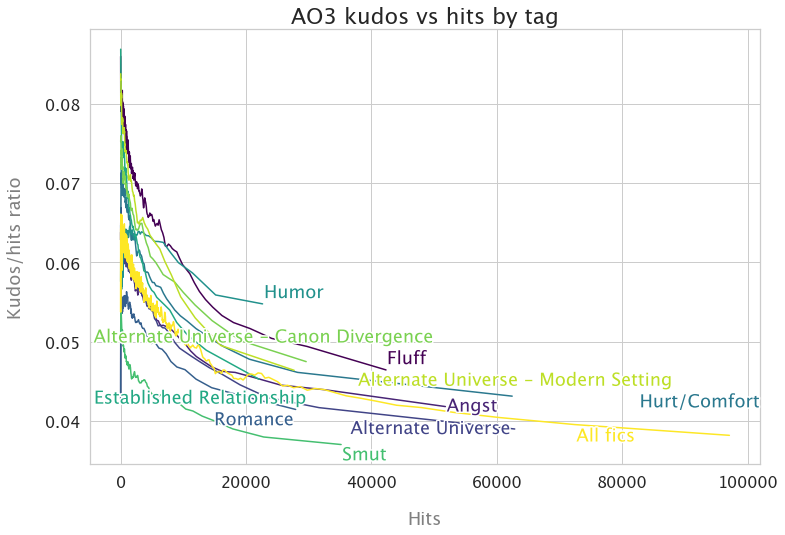

In [14]:
# We'll pull all the tag data & associate it with a number of hits.
# Sometimes a work is tagged with two tags that mean the same thing--let's get rid of those duplicates.
data = db.get_data('TagName', 'Kudos', 'Hits', 
                   conditions=["Hits IS NOT NULL"],
                   duplicates = False
                  )

data['TagName'] = data['TagName'].map(format_tag)
tag_counts = data['TagName'].value_counts()

canonical_tags = db.get_data('TagName', 'TagCategory')
canonical_tags['TagName'] = canonical_tags['TagName'].map(format_tag)

freeform = canonical_tags.loc[canonical_tags["TagCategory"]=="free"]
freeform_tag_counts = tag_counts.loc[tag_counts.index.isin(freeform['TagName'])].sort_values(ascending=False)
top_tags = freeform_tag_counts.index[:10]

interpolators = []
labels = []
for i, tag in enumerate(top_tags):
    this = data.query("TagName == '{}'".format(tag))
    labels.append(format_tag(tag))
    interpolators.append(downsample(this, "Hits", "Kudos"))
fig = hits_v_kudos_plot(interpolators, labels, kudos_vs_hits)
fig.gca().set_title("AO3 kudos vs hits by tag")
fig.savefig("kudos_v_hits_per_tag.png")

How do authors' kudos differ?

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


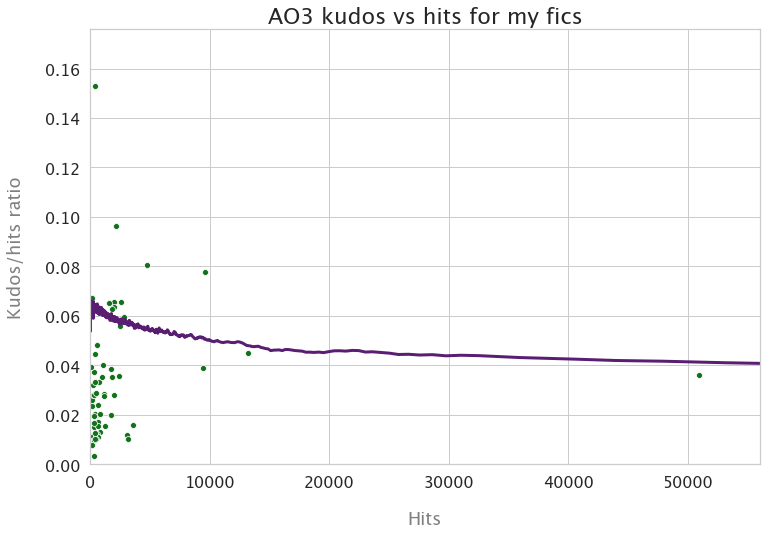

In [15]:
from scipy import interpolate
interp = interpolate.interp1d(kudos_vs_hits[0], kudos_vs_hits[1], fill_value='extrapolate')

data = db.get_data('Hits', 'Kudos', 'CreatorName', conditions=["CreatorName == 'goseaward'"])
data['Ratio'] = data['Kudos'].astype('float')/data['Hits'].astype('float')
fig, ax = plt.subplots()
ax.plot(kudos_vs_hits[0], rolling_mean(kudos_vs_hits[1]/kudos_vs_hits[0]), lw=3, color=sns.color_palette("dark")[4])
sns.scatterplot(x="Hits", y="Ratio", data=data, color=single_color)
ax.set_xlim((0, data['Hits'].max()*1.1))
ax.set_ylim((0, data['Ratio'].max()*1.15))
ax.set_ylabel("Kudos/hits ratio")
ax.set_title("AO3 kudos vs hits for my fics")
plt.savefig("my_hits_v_kudos.png")

My standard dev: Hits          6749.857931
Kudos          265.227004
KudosRatio       0.443650
Name: goseaward, dtype: float64


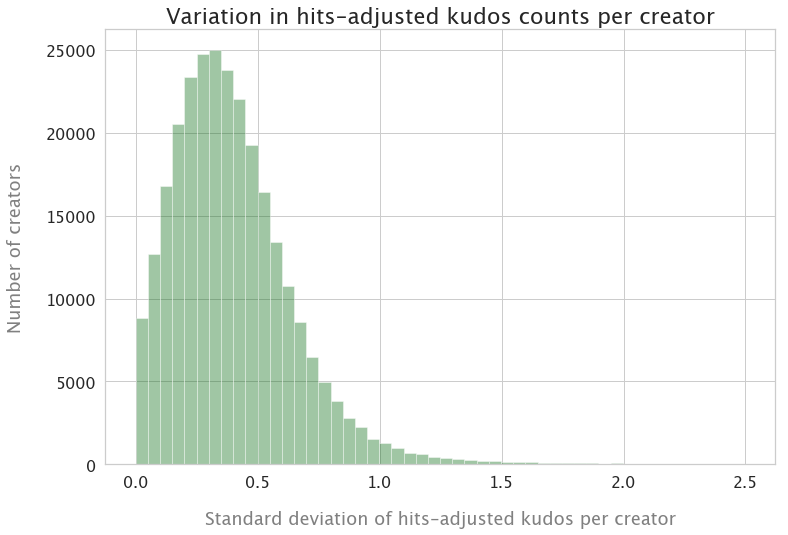

In [16]:
data = db.get_data("CreatorName", "Hits", "Kudos").dropna()
author_counts = data.groupby("CreatorName").sum().query("Hits>=1000")
data = data[data["CreatorName"].isin(author_counts.index)]

data["KudosRatio"] = data["Kudos"]/interp(data["Hits"])
stdev = data.groupby("CreatorName").std()
print("My standard dev: {}".format(stdev.loc['goseaward']))
stdev = stdev[stdev['KudosRatio']<2.5]


fig, ax = plt.subplots()
sns.distplot(stdev["KudosRatio"].dropna(), kde=False, ax=ax, color=single_color)
plt.xlabel("Standard deviation of hits-adjusted kudos per creator")
plt.ylabel("Number of creators")
ax.set_title("Variation in hits-adjusted kudos counts per creator")
plt.savefig("Author_variance.png")